## anaCElikecuts 

In [1]:
import uproot
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
plt.style.use("/exp/mu2e/data/users/sgrant/mu2e.mplstyle")
import numpy as np
import hist
import gc
import sys
from datetime import datetime

# sys.path.append("../../../EventNtuple/utils/pyutils")
from pyutils.pyprocess import Processor, Skeleton
from pyutils.pyplot import Plot
from pyutils.pyprint import Print
from pyutils.pyselect import Select
from pyutils.pyvector import Vector

sys.path.append("../common")
from cut_manager import CutManager
from analyse import Analyse

## Set file output tag

In [2]:
# Get today's date in MM-DD-YY format
today = datetime.now().strftime("%m-%d-%y")
# tag = "test_plot" # today
tag = today
spill = "offspill"

# Create Processor 

We inherit from Skeleton - this gives us many pre-built methods without writing extra code

In [39]:
# Create your custom processor class
class CosmicProcessor(Skeleton):
    """Your custom file processor 
    
    This class inherits from the Skeleton base class, which provides the 
    basic structure and methods withing the Processor framework 
    """
    def __init__(self,file_name,location):
        """Initialise your processor with specific configuration
        
        This method sets up all the parameters needed for this specific analysis.
        """
        # Call the parent class's __init__ method first
        # This ensures we have all the base functionality properly set up
        super().__init__()

        # Now override parameters from the Skeleton with the ones we need
        # Data selection configuration 
        # self.defname = "nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.root"
        self.file_name = file_name # "nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.001210_00000699.root"
    
        self.branches = { 
            "evt" : [
                "run",
                "subrun",
                "event",
            ],
            "crv" : [
                "crvcoincs.time",
                "crvcoincs.nHits",
                "crvcoincs.pos.fCoordinates.fZ"
            ],
            "trk" : [
                "trk.nactive", 
                "trk.pdg", 
                "trkqual.valid",
                "trkqual.result"
            ],
            "trkfit" : [
                "trksegs",
                "trksegpars_lh"
            ],
            "trkmc" : [
                "trkmcsim"
            ]
        }
        self.use_remote = True     # Use remote file via mdh
        self.location = location     # File location
        self.max_workers = 1      # Limit the number of workers
        self.verbosity = 2         # Set verbosity 
        self.use_processes = True  # Use processes rather than threads
        
        # Now add your own analysis-specific parameters 

        # Init analysis methods
        # Would be good to load an analysis config here 
        self.analyse = Analyse(
            # event_subrun=(93561, 25833), # select one event
            on_spill=True,
            verbosity=0
        )

        # Toggle cuts OFF 
        self.inactive_cuts = [ 
            "is_truth_electron",
            "is_reco_electron",
            "downstream",
            "good_trkqual",
            "has_hits",
            "within_lhr_max",
            "within_d0",
            "within_pitch_angle",
            "unvetoed"
        ]
            
        # Custom prefix for log messages from this processor
        self.print_prefix = "[CosmicProcessor] "
        print(f"{self.print_prefix}Initialised")
    
    # ==========================================
    # Define the core processing logic
    # ==========================================
    # This method overrides the parent class's process_file method
    # It will be called automatically for each file by the execute method
    def process_file(self, file_name): 
        """Process a single ROOT file
        
        This method will be called for each file in our list.
        It extracts data, processes it, and returns a result.
        
        Args:
            file_name: Path to the ROOT file to process
            
        Returns:
            A tuple containing the histogram (counts and bin edges)
        """
        try:
            # Create a local pyprocess Processor to extract data from this file
            # This uses the configuration parameters from our class
            this_processor = Processor(
                use_remote=self.use_remote,     # Use remote file via mdh
                location=self.location,         # File location
                verbosity=0 # self.verbosity        # Reduce output in worker threads
            )
            
            # Extract the data 
            this_data = this_processor.process_data(
                file_name = file_name, 
                branches = self.branches
            )
            
            # ---- Analysis ----            
            results = self.analyse.execute(
                data=this_data, 
                file_id=file_name,
                inactive_cuts=self.inactive_cuts
            )

            # Clean up
            gc.collect()

            return results 
        
        except Exception as e:
            # Handle any errors that occur during processing
            print(f"{self.print_prefix}Error processing {file_name}: {e}")
            return None

    ## Need postprocessing and failure handling!   


# Create an instance of our custom processor
# cosmic_processor = CosmicProcessor()

In [40]:
# ==========================================
# Run the processor
# ==========================================

# Run the processor on all files
# The execute method comes from the Skeleton parent class
# This starts a parent Processor and submits the process function to the threads

# Execute your processor
# Create an instance of our custom processor
cosmic_processor = CosmicProcessor(file_name="nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.001210_00000699.root",location="tape")

signalresults = cosmic_processor.execute()

[Skeleton] ⭐️ Skeleton init
[CosmicProcessor] Initialised
[Skeleton] ⭐️ Starting analysis
[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = tape
	schema = root
	verbosity=2
[pyprocess] ✅ Returning result from process on nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.001210_00000699.root
[Skeleton] ✅ Analysis complete


In [41]:
print(signalresults)

{'file_id': 'nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.001210_00000699.root', 'cut_stats': [{'name': 'No cuts', 'active': 'N/A', 'description': 'No selection applied', 'events_passing': 1471, 'absolute_frac': 100.0, 'relative_frac': 100.0}, {'name': 'one_reco_electron', 'active': True, 'description': 'One reco electron / event', 'mask': <Array [[True, True, True, True], ..., [True, ...]] type='1471 * var * bool'>, 'events_passing': 1463, 'absolute_frac': 99.45615227736234, 'relative_frac': 99.45615227736234}, {'name': 'within_t0', 'active': True, 'description': 't0 at tracker entrance (640 < t_0 < 1650 ns)', 'mask': <Array [[False, False, False, False], ..., [...]] type='1471 * var * bool'>, 'events_passing': 1079, 'absolute_frac': 73.35146159075458, 'relative_frac': 73.75256322624743}], 'filtered_data': <Array [{evt: {...}, crv: {...}, ...}, ...] type='1079 * {evt: {event: int3...'>, 'histograms': {'Wide range': Hist(
  Regular(30, 0, 300, name='momentum', labe

## Check results

In [58]:
# cosmic_processor = CosmicProcessor(file_name="nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.001202_00012335.root",location="disk")
cosmic_processor = CosmicProcessor(file_name="nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.001202_00012335.root",location="disk")

backgroundresults = cosmic_processor.execute()

# # This handles single files 
# if not isinstance(results, list):
#     results = [results]

# print(results[0])

NameError: name 'self' is not defined

In [43]:
print(backgroundresults)

{'file_id': 'nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.001202_00012335.root', 'cut_stats': [{'name': 'No cuts', 'active': 'N/A', 'description': 'No selection applied', 'events_passing': 2653, 'absolute_frac': 100.0, 'relative_frac': 100.0}, {'name': 'one_reco_electron', 'active': True, 'description': 'One reco electron / event', 'mask': <Array [[True, True, True, True], ..., [False, ...]] type='2653 * var * bool'>, 'events_passing': 2100, 'absolute_frac': 79.15567282321899, 'relative_frac': 79.15567282321899}, {'name': 'within_t0', 'active': True, 'description': 't0 at tracker entrance (640 < t_0 < 1650 ns)', 'mask': <Array [[True, True, True, True], ..., [False, ...]] type='2653 * var * bool'>, 'events_passing': 1728, 'absolute_frac': 65.13381078024878, 'relative_frac': 82.28571428571428}], 'filtered_data': <Array [{evt: {...}, crv: {...}, ...}, ...] type='131 * {evt: {event: int32...'>, 'histograms': {'Wide range': Hist(
  Regular(30, 0, 300, name='mom

## Print cut statistics

In [44]:
def converttolist(results):
    if not isinstance(results, list):
        results = [results]
    return results

signalresults = converttolist(signalresults)
backgroundresults = converttolist(backgroundresults)

# # Helper to convert the cut stats into a list 
# def get_stats_list(results):
#     stats = [] 
#     if isinstance(results, list): 
#         for result in results: 
#             if "cut_stats" in result: 
#                 stats.append(result["cut_stats"])
#     else: 
#         stats.append(results["cut_stats"])
#     return stats

# stats = get_stats_list(results)

# cut_manager = CutManager()
# combined_stats = cut_manager.combine_cut_stats(stats)
# cut_manager.print_cut_stats(stats=combined_stats, active_only=True, csv_name=f"../../txt/cut_stats_{spill}_{tag}.csv")

In [45]:
# results[0].keys()

In [46]:
print(signalresults)
print()
print(backgroundresults)

[{'file_id': 'nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.001210_00000699.root', 'cut_stats': [{'name': 'No cuts', 'active': 'N/A', 'description': 'No selection applied', 'events_passing': 1471, 'absolute_frac': 100.0, 'relative_frac': 100.0}, {'name': 'one_reco_electron', 'active': True, 'description': 'One reco electron / event', 'mask': <Array [[True, True, True, True], ..., [True, ...]] type='1471 * var * bool'>, 'events_passing': 1463, 'absolute_frac': 99.45615227736234, 'relative_frac': 99.45615227736234}, {'name': 'within_t0', 'active': True, 'description': 't0 at tracker entrance (640 < t_0 < 1650 ns)', 'mask': <Array [[False, False, False, False], ..., [...]] type='1471 * var * bool'>, 'events_passing': 1079, 'absolute_frac': 73.35146159075458, 'relative_frac': 73.75256322624743}], 'filtered_data': <Array [{evt: {...}, crv: {...}, ...}, ...] type='1079 * {evt: {event: int3...'>, 'histograms': {'Wide range': Hist(
  Regular(30, 0, 300, name='momentum', lab

In [47]:
signal=signalresults[0]["filtered_data"]
background=backgroundresults[0]["filtered_data"]

# def combine_arrays(results):
#     """Combine filtered arrays from multiple files
#     """
#     arrays_to_combine = []
#     # Check if we have results
#     # if not results:
#     #     return None
#     # Loop through all files
#     for result in results: #
#         array = ak.Array(result["filtered_data"])
#         if len(array) == 0:
#             continue
#         # Concatenate arrays
#         arrays_to_combine.append(array)
#     return ak.concatenate(arrays_to_combine)

# signal = combine_arrays(signalresults)
# background = combine_arrays(backgroundresults)

In [48]:
print(signal)
print()
print(background)
help(plot.plot_1D_overlay)

[{evt: {event: 5, run: 1210, ...}, crv: {...}, at_trk_front: [...], ...}, ...]

[{evt: {event: 106486, run: 1202, ...}, crv: {...}, ...}, ..., {evt: ..., ...}]
Help on method plot_1D_overlay in module pyutils.pyplot:

plot_1D_overlay(hists_dict, weights=None, nbins=100, xmin=-1.0, xmax=1.0, title=None, xlabel=None, ylabel=None, out_path=None, dpi=300, leg_pos='best', log_x=False, log_y=False, norm_by_area=False, ax=None, show=True) method of pyutils.pyplot.Plot instance
    Overlay multiple 1D histograms from a dictionary of arrays.

    Args:
        hists_dict (Dict[str, np.ndarray]): Dictionary mapping labels to arrays
        weights (List[np.ndarray], optional): List of weight arrays for each histogram
        nbins (int, optional): Number of bins. Defaults to 100
        xmin (float, optional): Minimum x-axis value. Defaults to -1.0
        xmax (float, optional): Maximum x-axis value. Defaults to 1.0
        title (str, optional): Plot title
        xlabel (str, optional): X-axi

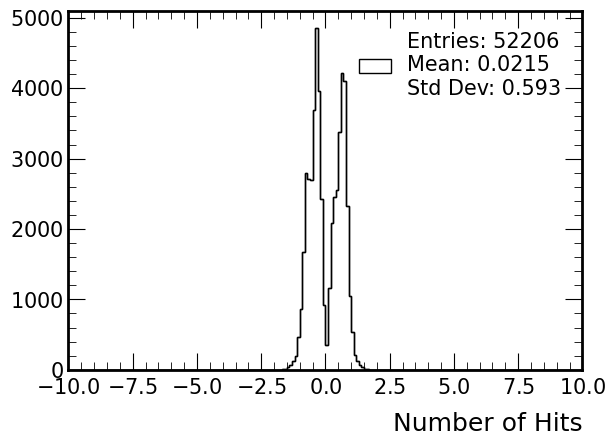

In [81]:
plot.plot_1D(
    ak.flatten(signal["trkfit"]["trksegpars_lh"]["tanDip"],axis=None),#"CosmicCRY":nhits_background},
    nbins=200,xmin=-10,xmax=10,#norm_by_area=Truehow
#=False,
    xlabel="Number of Hits"
)
plot.plot_1D_overlay(
    {"CEEndpoint":nhits_signal,"CosmicCRY":nhits_background},
    nbins=100,xmin=0,xmax=100,norm_by_area=True,
    ax=ax, 
    show=False,
    xlabel="Number of Hits"
)

ax.axvline(20, linestyle="--", color="grey")
plt.show()



[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1


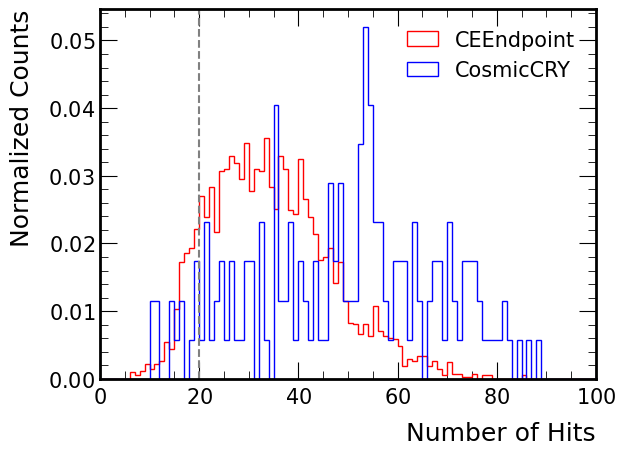

In [86]:
plot=Plot()
nhits_signal = ak.flatten(signal["trk"]["trk.nactive"],axis=None)
nhits_background = ak.flatten(background["trk"]["trk.nactive"],axis=None)

fig, ax = plt.subplots()
plot.plot_1D_overlay(
    {"CEEndpoint":nhits_signal,"CosmicCRY":nhits_background},
    nbins=100,xmin=0,xmax=100,norm_by_area=True,
    ax=ax, 
    show=False,
    xlabel="Number of Hits",
    ylabel="Normalized Counts"
)

ax.axvline(20, linestyle="--", color="grey")
plt.show()

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1


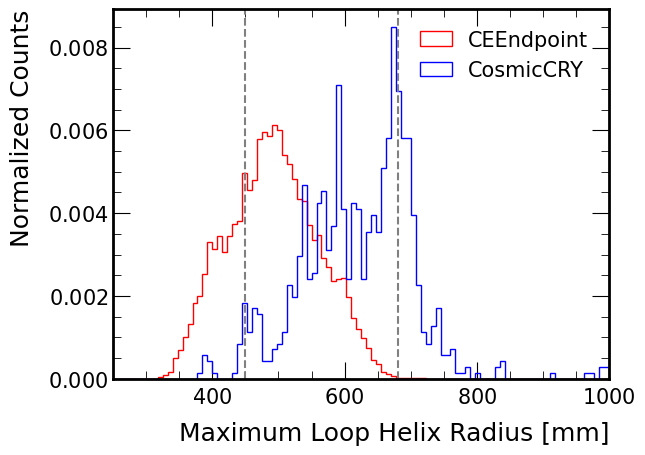

In [91]:
plot=Plot()
nhits_signal = ak.flatten(signal["trkfit"]["trksegpars_lh"]["maxr"],axis=None)
nhits_background = ak.flatten(background["trkfit"]["trksegpars_lh"]["maxr"],axis=None)

fig, ax = plt.subplots()
plot.plot_1D_overlay(
    {"CEEndpoint":nhits_signal,"CosmicCRY":nhits_background},
    nbins=100,xmin=250,xmax=1000,norm_by_area=True,
    ax=ax, 
    show=False,
    xlabel="Maximum Loop Helix Radius [mm]",
    ylabel="Normalized Counts"
)

ax.axvline(450, linestyle="--", color="grey")
ax.axvline(680, linestyle="--", color="grey")
plt.show()

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1


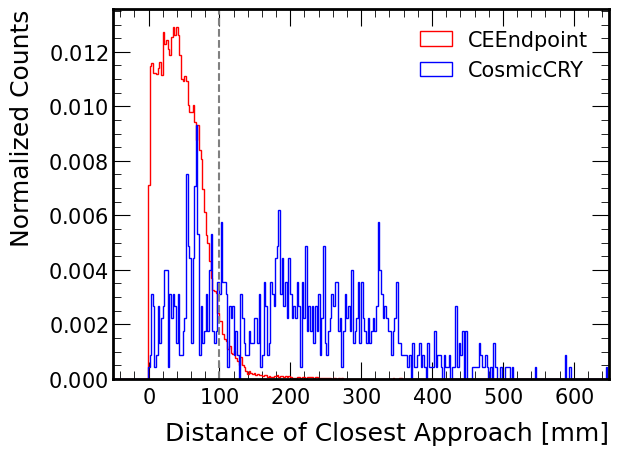

In [88]:
plot=Plot()
nhits_signal = ak.flatten(signal["trkfit"]["trksegpars_lh"]["d0"],axis=None)
nhits_background = ak.flatten(background["trkfit"]["trksegpars_lh"]["d0"],axis=None)

fig, ax = plt.subplots()
plot.plot_1D_overlay(
    {"CEEndpoint":nhits_signal,"CosmicCRY":nhits_background},
    nbins=300,xmin=-50,xmax=650,norm_by_area=True,
    ax=ax,
    show=False,
    xlabel="Distance of Closest Approach [mm]",
    ylabel="Normalized Counts"
)

ax.axvline(100, linestyle="--", color="grey")
plt.show()

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1


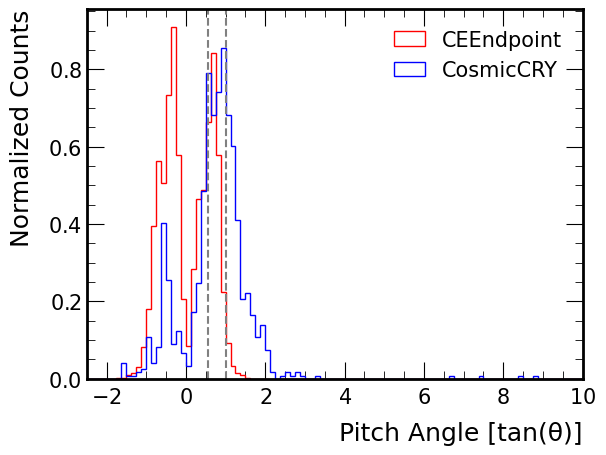

In [95]:
plot=Plot()
nhits_signal = ak.flatten(signal["trkfit"]["trksegpars_lh"]["tanDip"],axis=None)
nhits_background = ak.flatten(background["trkfit"]["trksegpars_lh"]["tanDip"],axis=None)

fig, ax = plt.subplots()
plot.plot_1D_overlay(
    {"CEEndpoint":nhits_signal,"CosmicCRY":nhits_background},
    nbins=100,xmin=-2.5,xmax=10,norm_by_area=True,
    ax=ax,
    show=False,
    xlabel="Pitch Angle [tan(θ)]",
    ylabel="Normalized Counts"
)

ax.axvline(0.5577350, linestyle="--", color="grey")
ax.axvline(1.0, linestyle="--", color="grey")
plt.show()

In [53]:
help(plot.plot_1D_overlay)

Help on method plot_1D_overlay in module pyutils.pyplot:

plot_1D_overlay(hists_dict, weights=None, nbins=100, xmin=-1.0, xmax=1.0, title=None, xlabel=None, ylabel=None, out_path=None, dpi=300, leg_pos='best', log_x=False, log_y=False, norm_by_area=False, ax=None, show=True) method of pyutils.pyplot.Plot instance
    Overlay multiple 1D histograms from a dictionary of arrays.

    Args:
        hists_dict (Dict[str, np.ndarray]): Dictionary mapping labels to arrays
        weights (List[np.ndarray], optional): List of weight arrays for each histogram
        nbins (int, optional): Number of bins. Defaults to 100
        xmin (float, optional): Minimum x-axis value. Defaults to -1.0
        xmax (float, optional): Maximum x-axis value. Defaults to 1.0
        title (str, optional): Plot title
        xlabel (str, optional): X-axis label
        ylabel (str, optional): Y-axis label
        out_path (str, optional): Path to save the plot
        dpi (int, optional): DPI for saved plot. De